## MNIST dataset classification using PyTorch
MNIST dataset include hand written numbers 0-9. One of the "easiest" case studies for computer vision practice.

### Imports

In [37]:
import time

import torchvision
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(os.getcwd())

C:\Users\reuve\PycharmProjects\PyTorch\my_projects\computer_vision_projects\image_classification


#### Initializations
1) Set the data path
2) Set the device (cpu or gpu)
3) Define the train and test datasets

In [39]:
data_path = "../../../data"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# without the transform we get 0-255 values (raw data).
transform = transforms.Compose(
    [transforms.ToTensor(), # normalizes to 0 to 1 range.
     transforms.Normalize((0.5,), (0.5,))]) # This further normalizes to [-1, 1], image = (image - mean) / std

train_dataset = torchvision.datasets.MNIST(root=data_path, train=True, download=True, transform=transform) 
test_dataset = torchvision.datasets.MNIST(root=data_path, train=False, download=True, transform=transform)


print(f"train dataset is {len(train_dataset)}")
print(f"test dataset is {len(test_dataset)}")


# The the number of classes.
num_classes = len(train_dataset.classes)
print(num_classes)

class_names = train_dataset.classes
print(class_names)

train dataset is 60000
test dataset is 10000
10
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


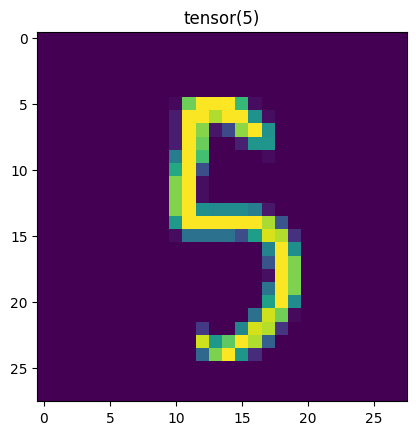

tensor(255, dtype=torch.uint8)


In [14]:
# Analyze a single image.
random_idx = random.randint(0, train_dataset.data.shape[0]) # getting an image this way doesn't apply the transform!
image = train_dataset.data[random_idx]
label = train_dataset.targets[random_idx]
plt.imshow(image)
plt.title(label)
plt.show()

In [16]:
# Define the dataloaders
batch_size = 32 
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

#### Define different types of NN models (from scratch)

In [32]:
# Build the simplest neural network. This would just be a linear neural network.
class mnistNN_linear(nn.Module): 
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, output_size)

    def forward(self, input_tensor):
        output = self.fc1(input_tensor.flatten(1))
        return output

# One step above this would be to add non-linearity
class mnistNN_nonlinear(nn.Module): 
    def __init__(self, input_size, middle_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, middle_size)
        self.fc2 = nn.Linear(middle_size, output_size)

    def forward(self, input_tensor):
        output = F.relu(self.fc1(input_tensor.flatten(1)))
        output = self.fc2(output)
        
        return output

# And for full complexity we can now add convolution layers.
class mnistNN_CNN(nn.Module): 
    def __init__(self, input_size, num_classes):
        super(mnistNN_CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_size[0], 32, kernel_size=5), # shape changed to batch_size * 32 * 24 * 24
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)) # shape changed to batch_size * 32 * 12 * 12
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5), # shape changed to batch_size * 64 * 8 * 8
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)) # shape changed to batch_size * 64 * 4 * 4
        self.fc1 = nn.Linear(4 * 4 * 64, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        return x


#### Set the train loop

In [29]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    output = model(xb)
    loss = loss_func(output, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    _, prediction = torch.max(output, 1)
    return loss.item(), len(xb), prediction


def train(epochs, train_dataloader, model, optimizer, loss_func, device_train='cpu', print_every=100, disp_params=True, save_model_name=' '):
    train_losses = []
    test_losses = []
    test_accuracy = []
    model.train()
    optimizer.zero_grad()
    start_time = time.time()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0 
        total = 0
        losses = []
        nums = []
        model.train()
        for i, data in enumerate(train_dataloader):
            images, labels = data
            images = images.to(device_train)
            labels = labels.to(device_train)
            loss, N, predictions = loss_batch(model, loss_func, images, labels, opt=optimizer)
            losses.append(loss)
            nums.append(N)
            
            total += N
            correct += predictions.eq(labels).sum().item()
            running_loss += loss
            if disp_params:
                if i % print_every == print_every - 1:
                    print(f'[{epoch + 1}, {i + 1:5d}] | loss: {running_loss / print_every:.3f} | Train Acc: {100.*correct/total:.2f}%")')
                    running_loss = 0.0
                    correct = 0
                    total = 0

        # Append mean train loss per epoch.
        train_losses.append(np.sum(np.multiply(np.array(losses), np.array(nums))) / np.sum(np.array(nums)))
        
        # Confirm results with test data:
        model.eval()
        with torch.no_grad():
            losses = []
            nums = []
            all_predictions = []
            all_true_labels = []
            correct = 0
            total = 0
            for b, batch in enumerate(test_dataloader):
                images = batch[0].to(device_train)
                labels = batch[1].to(device_train)
                loss, num, predictions = loss_batch(model, loss_func, images, labels)
                losses.append(loss)
                nums.append(num)
                all_predictions.extend(predictions.cpu())
                all_true_labels.extend(batch[1])
                correct += predictions.eq(labels).sum().item()
                total += num
        
        # Append mean test loss per epoch.
        val_test_loss = np.sum(np.multiply(np.array(losses), np.array(nums))) / np.sum(np.array(nums))
        test_losses.append(val_test_loss)
        test_accuracy.append(100.*correct/total)

        if disp_params:
            print(f"Finished Epoch #{epoch + 1}")
            print(f"Test value loss: {val_test_loss} | Test Acc: {100.*correct/total:.2f}%")

    if disp_params:
        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_true_labels)
        cm = confusion_matrix(all_labels, all_predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(xticks_rotation='vertical')
    
        plt.figure()
        plt.plot(train_losses)
        plt.title("train losses")
    
        plt.figure()
        plt.plot(test_losses)
        plt.title("test losses")
    
        plt.show()
    
    end_time = time.time()
    print(f"training took {end_time - start_time}s")

    if save_model_name is not None:
        model_path = (f"./mnist_model_{save_model_name}")
        torch.save(model.state_dict(), model_path)

    return train_losses, test_losses, test_accuracy

#### Perform training and testing for three model types.

[1,   100] | loss: 1.124 | Train Acc: 67.81%")
[1,   200] | loss: 0.577 | Train Acc: 83.75%")
[1,   300] | loss: 0.500 | Train Acc: 85.78%")
[1,   400] | loss: 0.437 | Train Acc: 87.66%")
[1,   500] | loss: 0.392 | Train Acc: 88.94%")
[1,   600] | loss: 0.379 | Train Acc: 89.12%")
[1,   700] | loss: 0.398 | Train Acc: 88.41%")
[1,   800] | loss: 0.384 | Train Acc: 88.59%")
[1,   900] | loss: 0.356 | Train Acc: 89.31%")
[1,  1000] | loss: 0.372 | Train Acc: 89.62%")
[1,  1100] | loss: 0.365 | Train Acc: 88.72%")
[1,  1200] | loss: 0.348 | Train Acc: 89.81%")
[1,  1300] | loss: 0.357 | Train Acc: 89.78%")
[1,  1400] | loss: 0.350 | Train Acc: 89.94%")
[1,  1500] | loss: 0.346 | Train Acc: 90.31%")
[1,  1600] | loss: 0.331 | Train Acc: 89.78%")
[1,  1700] | loss: 0.336 | Train Acc: 90.16%")
[1,  1800] | loss: 0.336 | Train Acc: 89.91%")
Finished Epoch #1
Test value loss: 0.3157907967329025 | Test Acc: 90.91%
[2,   100] | loss: 0.334 | Train Acc: 90.16%")
[2,   200] | loss: 0.323 | Train A

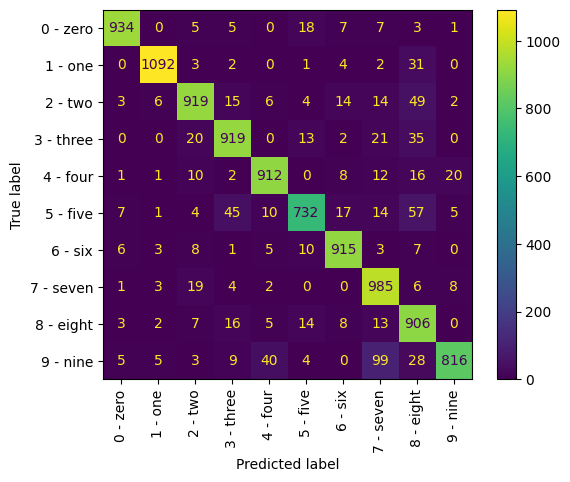

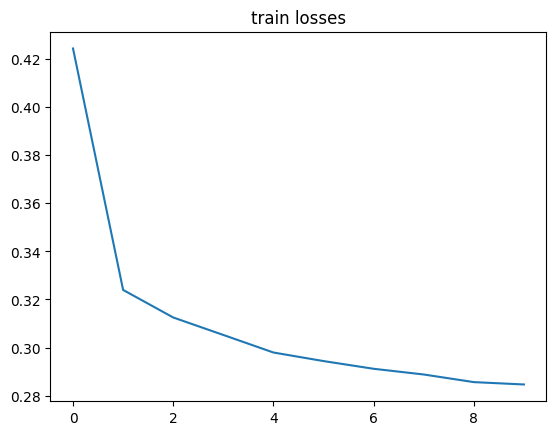

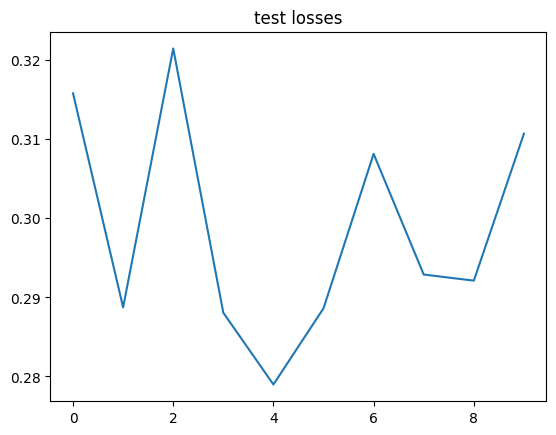

training took 243.17243885993958s


In [41]:
# Train and test data with simple linear model
print_every = 100
epochs = 10

input_size = 28 * 28 # 784
output_size = 10 # number of targets
model = mnistNN_linear(input_size, output_size)
model.to(device)

loss_function = nn.CrossEntropyLoss() # This loss requires the data to NOT be activated since it performs the activation inside.
optimizer = optim.Adam(model.parameters())

model_type = "linear"

train_losses, test_losses, test_accuracy = train(epochs, train_dataloader, model, 
                                                 optimizer, loss_function, device, print_every, disp_params=True, save_model_name=model_type)

# This model achieves about 92% accuracy about 10 epochs, and it doesn't look like more epochs would do much to help.

[1,   100] | loss: 0.907 | Train Acc: 72.44%")
[1,   200] | loss: 0.455 | Train Acc: 85.72%")
[1,   300] | loss: 0.433 | Train Acc: 86.75%")
[1,   400] | loss: 0.357 | Train Acc: 89.25%")
[1,   500] | loss: 0.348 | Train Acc: 89.50%")
[1,   600] | loss: 0.329 | Train Acc: 90.41%")
[1,   700] | loss: 0.323 | Train Acc: 90.38%")
[1,   800] | loss: 0.276 | Train Acc: 91.25%")
[1,   900] | loss: 0.250 | Train Acc: 91.94%")
[1,  1000] | loss: 0.249 | Train Acc: 92.41%")
[1,  1100] | loss: 0.228 | Train Acc: 93.22%")
[1,  1200] | loss: 0.259 | Train Acc: 92.28%")
[1,  1300] | loss: 0.224 | Train Acc: 93.28%")
[1,  1400] | loss: 0.214 | Train Acc: 93.84%")
[1,  1500] | loss: 0.228 | Train Acc: 93.84%")
[1,  1600] | loss: 0.204 | Train Acc: 93.81%")
[1,  1700] | loss: 0.189 | Train Acc: 94.09%")
[1,  1800] | loss: 0.206 | Train Acc: 94.03%")
Finished Epoch #1
Test value loss: 0.17592545562386513 | Test Acc: 94.44%
[2,   100] | loss: 0.168 | Train Acc: 95.19%")
[2,   200] | loss: 0.180 | Train 

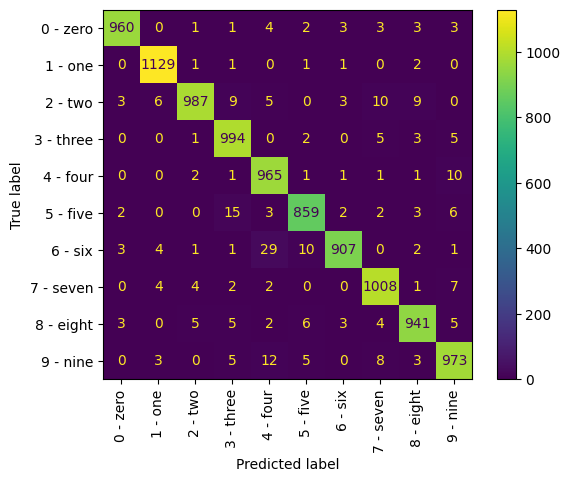

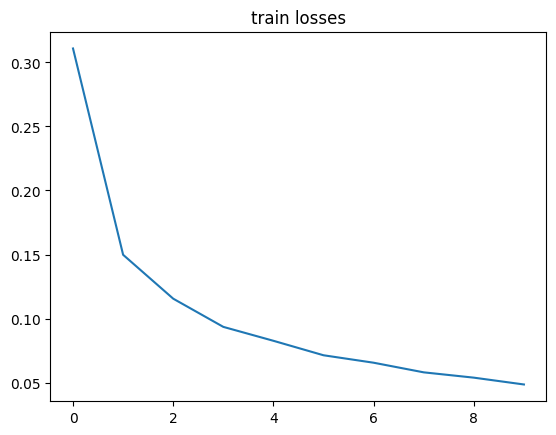

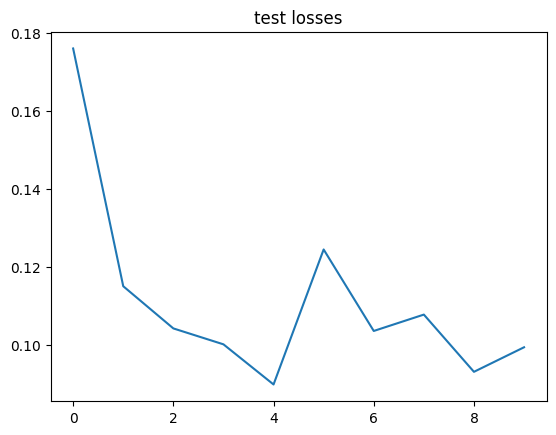

training took 287.062038898468s


In [42]:
# Train and test data with the non-linear model
input_size = 28 * 28 # 784
middle_size = 254
output_size = 10 # number of targets
model = mnistNN_nonlinear(input_size, middle_size, output_size)

model.to(device)

loss_function = nn.CrossEntropyLoss() # This loss requires the data to NOT be activated since it performs the activation inside.
optimizer = optim.Adam(model.parameters())

model_type = "nonlinear"

train_losses, test_losses, test_accuracy = train(epochs, train_dataloader, model, 
                                                 optimizer, loss_function, device, print_every, disp_params=True, save_model_name=model_type)

# This model achieves about 97% accuracy about 10 epochs. Again, after 4 epochs we don't see much improvement in the test data.

[1,   100] | loss: 0.696 | Train Acc: 80.25%")
[1,   200] | loss: 0.217 | Train Acc: 93.78%")
[1,   300] | loss: 0.144 | Train Acc: 95.38%")
[1,   400] | loss: 0.127 | Train Acc: 96.12%")
[1,   500] | loss: 0.104 | Train Acc: 96.69%")
[1,   600] | loss: 0.088 | Train Acc: 97.19%")
[1,   700] | loss: 0.076 | Train Acc: 97.97%")
[1,   800] | loss: 0.093 | Train Acc: 97.38%")
[1,   900] | loss: 0.079 | Train Acc: 97.62%")
[1,  1000] | loss: 0.062 | Train Acc: 98.16%")
[1,  1100] | loss: 0.067 | Train Acc: 97.88%")
[1,  1200] | loss: 0.058 | Train Acc: 98.06%")
[1,  1300] | loss: 0.066 | Train Acc: 98.12%")
[1,  1400] | loss: 0.049 | Train Acc: 98.34%")
[1,  1500] | loss: 0.066 | Train Acc: 97.94%")
[1,  1600] | loss: 0.061 | Train Acc: 98.31%")
[1,  1700] | loss: 0.056 | Train Acc: 98.31%")
[1,  1800] | loss: 0.062 | Train Acc: 98.28%")
Finished Epoch #1
Test value loss: 0.05524061798052862 | Test Acc: 98.25%
[2,   100] | loss: 0.048 | Train Acc: 98.50%")
[2,   200] | loss: 0.054 | Train 

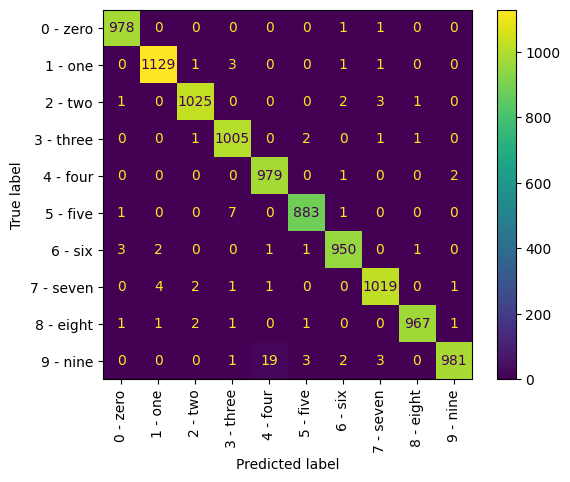

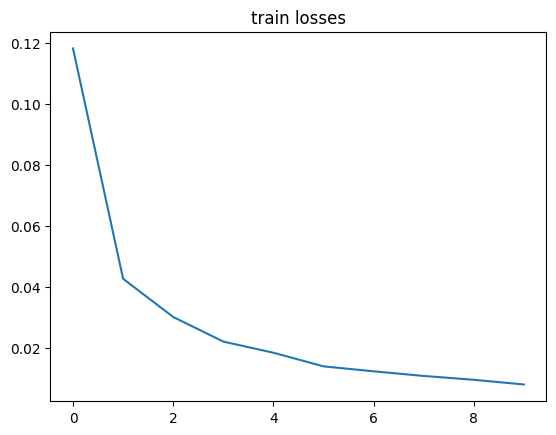

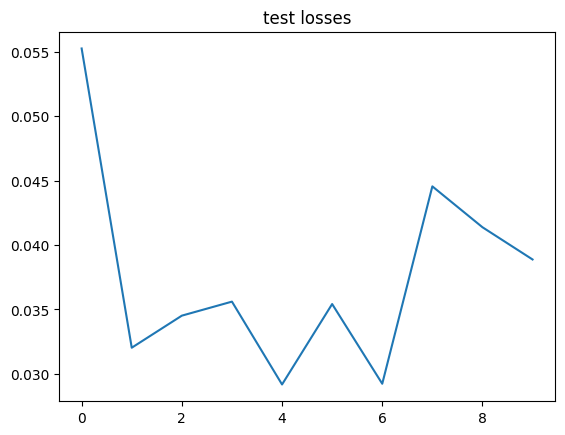

training took 304.5922794342041s


In [43]:
# Train and test data with the CNN model
output_size = 10 # number of targets
model = mnistNN_CNN((1, 28, 28), output_size)

model.to(device)

loss_function = nn.CrossEntropyLoss() # This loss requires the data to NOT be activated since it performs the activation inside.
optimizer = optim.Adam(model.parameters())

model_type = "CNN"

train_losses, test_losses, test_accuracy = train(epochs, train_dataloader, model, 
                                                 optimizer, loss_function, device, print_every, disp_params=True, save_model_name=model_type)

# Unsurprisingly, the CNN model is superior and achieves above 99% accuracy after 10 epochs.

#### Compare with the simplest of the ResNet models

In [49]:
# Load the resnet-18 model.
# We use the model here for its architechture, not the pre-trained weights.
resnet_model = torchvision.models.resnet18()
print(resnet_model.eval())


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Adapt the MNIST data to resnet model.
1) Add more channels - expects three
2) modify to 10 output classes.

In [56]:
# 1) 
transform = transforms.Compose(
    [transforms.ToTensor(), # normalizes to 0 to 1 range.
     transforms.Normalize((0.5,), (0.5,)), # This further normalizes to [-1, 1], image = (image - mean) / std
     transforms.Lambda(lambda x: x.repeat(3, 1, 1))]) # Resnet expects RGB input, so we need to increase the channel dimensions.

train_dataset = torchvision.datasets.MNIST(root=data_path, train=True, download=True, transform=transform) 
test_dataset = torchvision.datasets.MNIST(root=data_path, train=False, download=True, transform=transform)

batch_size = 32 
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)


# 2) 
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, num_classes)
print(resnet_model.fc)


Linear(in_features=512, out_features=10, bias=True)
10


[1,   100] | loss: 0.512 | Train Acc: 83.56%")
[1,   200] | loss: 0.241 | Train Acc: 92.53%")
[1,   300] | loss: 0.219 | Train Acc: 94.16%")
[1,   400] | loss: 0.170 | Train Acc: 95.22%")
[1,   500] | loss: 0.159 | Train Acc: 95.31%")
[1,   600] | loss: 0.149 | Train Acc: 95.75%")
[1,   700] | loss: 0.141 | Train Acc: 95.66%")
[1,   800] | loss: 0.154 | Train Acc: 95.44%")
[1,   900] | loss: 0.108 | Train Acc: 96.59%")
[1,  1000] | loss: 0.116 | Train Acc: 96.84%")
[1,  1100] | loss: 0.105 | Train Acc: 96.84%")
[1,  1200] | loss: 0.119 | Train Acc: 96.69%")
[1,  1300] | loss: 0.092 | Train Acc: 97.16%")
[1,  1400] | loss: 0.075 | Train Acc: 97.69%")
[1,  1500] | loss: 0.085 | Train Acc: 97.62%")
[1,  1600] | loss: 0.115 | Train Acc: 96.66%")
[1,  1700] | loss: 0.068 | Train Acc: 98.12%")
[1,  1800] | loss: 0.074 | Train Acc: 98.12%")
Finished Epoch #1
Test value loss: 0.0829683430897072 | Test Acc: 97.67%
[2,   100] | loss: 0.055 | Train Acc: 98.56%")
[2,   200] | loss: 0.067 | Train A

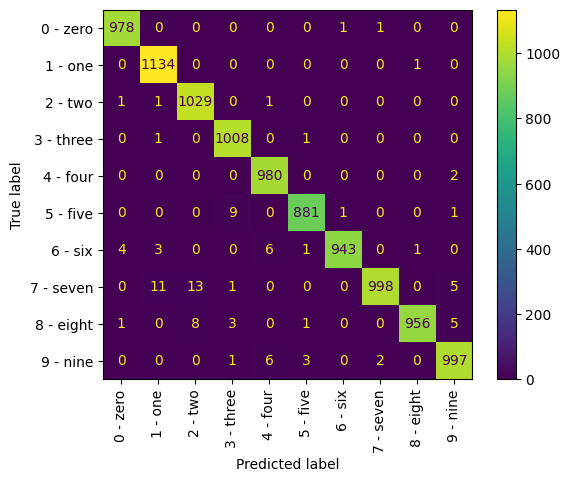

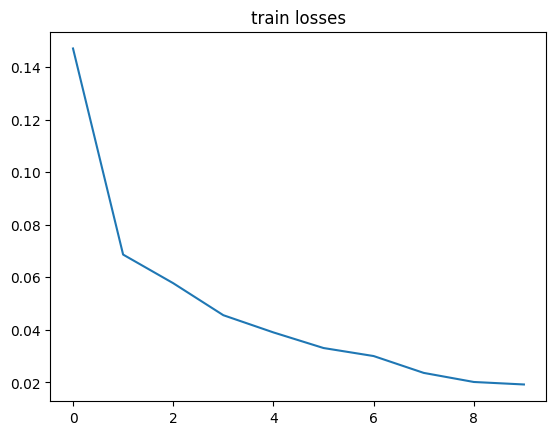

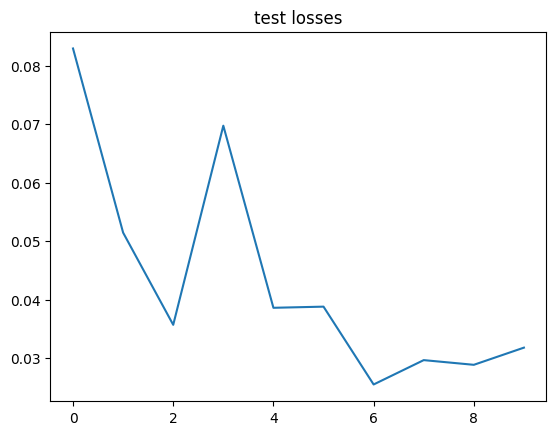

training took 873.711697101593s


In [57]:
# Train and test data with the RESNET18 model configuration (no default weights)
resnet_model.to(device)

loss_function = nn.CrossEntropyLoss() # This loss requires the data to NOT be activated since it performs the activation inside.
optimizer = optim.Adam(resnet_model.parameters())

model_type = "resnet_18_weights"

train_losses, test_losses, test_accuracy = train(epochs, train_dataloader, resnet_model, 
                                                 optimizer, loss_function, device, print_every, disp_params=True, save_model_name=model_type)

# Resnet model yields similar results (~99%) to a much simpler CNN model.

### Summary
In the excersize above we've seen that a non-linear NN model is prefereable to a linear model, while a convolutional (also nonlinear) NN model performs best for image classification of hand-written letters.
However, CNN complexity doesn't necessarily improve the result, as seen by comparing a simple 2-layer CNN and the 18-layer Resnet18 model. Moreover, when taking computational cost into account, the simple CNN takes only ~1/3 of the time to perform the same task.